In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from glob import iglob

In [2]:
dfs = []

# Read all files into dataframes
for f in iglob('data/raw/' + '*.csv'):
    temp_df = pd.read_csv(f, skiprows=[0], low_memory=False)
    dfs.append(temp_df)

In [3]:
# Get the columns that are consistent in all years
dropped_cols = []
cols = list(dfs[0].columns)
for i in range(1,len(dfs)):
    column_difference = set(cols).difference(set(dfs[i].columns))
    for c in column_difference:
        cols.remove(c)
        dropped_cols.append(c)

In [4]:
dropped_cols

['hardship_start_date',
 'debt_settlement_flag',
 'hardship_loan_status',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'hardship_end_date',
 'orig_projected_additional_accrued_interest',
 'settlement_status',
 'payment_plan_start_date',
 'deferral_term',
 'open_act_il',
 'hardship_status',
 'hardship_amount',
 'hardship_reason',
 'hardship_payoff_balance_amount',
 'settlement_amount',
 'settlement_term',
 'sec_app_open_act_il',
 'hardship_dpd',
 'settlement_date',
 'hardship_type',
 'disbursement_method',
 'hardship_length',
 'hardship_flag',
 'settlement_percentage']

In [317]:
data = dfs[0][cols]
for i in range(1, len(dfs)):
    data = data.append(dfs[i][cols])

In [318]:
data = data.reset_index(drop=True)

In [2]:
# data for 2015: 128 columns
# data = pd.read_csv('data/raw/LoanStats3d_securev1.csv',skiprows=[0], low_memory=False)

In [319]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,145217616,NaN,10000,10000,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,145640422,NaN,2500,2500,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,145630143,NaN,12000,12000,12000.0,60 months,13.56%,276.49,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145127870,NaN,15000,15000,14975.0,60 months,14.47%,352.69,C,C2,...,664.0,Oct-99,0.0,0.0,16.0,48.8,15.0,0.0,0.0,NaN
4,145558466,NaN,16000,16000,16000.0,60 months,17.97%,406.04,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
data['loan_status'].value_counts()

Current               2086919
Fully Paid             552459
Charged Off            131231
Late (31-120 days)      32304
In Grace Period         22089
Issued                  21294
Late (16-30 days)        8147
Default                    29
Name: loan_status, dtype: int64

In [321]:
data = data[data['loan_status'].str.lower().isin(['fully paid', 'charged off'])]

In [322]:
data['application_type'].value_counts()

INDIVIDUAL    595373
Individual     77967
Joint App       8214
JOINT           1411
DIRECT_PAY       725
Name: application_type, dtype: int64

In [323]:
data = data[data['application_type'].str.lower()=='individual']

In [324]:
data.shape[0]

673340

In [325]:
# (data['open_il_6m'][data['open_il_6m'].isnull() == False]).sum()

In [326]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.864689
mths_since_last_delinq                 0.515172
mths_since_last_record                 0.838423
next_pymnt_d                           1.000000
mths_since_last_major_derog            0.743672
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.752694
open_il_12m                            0.752693
open_il_24m                            0.752693
mths_since_rcnt_il                     0.758284
total_bal_il                           0.752693
il_util                                0.786271
open_rv_12m                            0.752693
open_rv_24m                            0.752693
max_bal_bc                             0.752693
all_util                               0.752730
inq_fi                                 0.752693
total_cu_tl                            0

In [327]:
drop = ['member_id', 
        'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 
        'revol_bal_joint', 'sec_app_fico_range_low', 
        'sec_app_fico_range_high',
        'sec_app_earliest_cr_line', 
        'sec_app_inq_last_6mths',
        'sec_app_mort_acc', 
        'sec_app_open_acc',
        'sec_app_revol_util',
#         'sec_app_open_il_6m', 
        'sec_app_num_rev_accts',
        'sec_app_chargeoff_within_12_mths',
        'sec_app_collections_12_mths_ex_med',
        'sec_app_mths_since_last_major_derog',
        'funded_amnt_inv', 
        'grade',
        'emp_title', 
        'emp_length',
        'pymnt_plan',
        'url',
        'title',
        'zip_code',
        'addr_state',
        'earliest_cr_line',
        'fico_range_high',
        'initial_list_status',
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_credit_pull_d', 
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'acc_now_delinq',
        'tot_coll_amt',
        'tot_cur_bal',
        'delinq_amnt' 
       ]
# data = data.drop(drop, axis=1)

In [328]:
data.purpose.unique()

array(['credit_card', 'debt_consolidation', 'other', 'house',
       'small_business', 'moving', 'home_improvement', 'car', 'vacation',
       'medical', 'major_purchase', 'renewable_energy', 'wedding',
       'educational'], dtype=object)

In [329]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [330]:
terms = {' 60 months': 60, ' 36 months': 36}
data['term'] = data['term'].apply(lambda x: terms[x])

In [331]:
def convert_pct(x):
    """
    Converts string with % to a float, handles 'None's.
    """
    if x is None or pd.isnull(x):
        return None
    return float(re.sub('%', '', x))

In [332]:
percent = ['revol_util', 'int_rate']
for p in percent:
    data[p] = data[p].apply(convert_pct)

In [333]:
# Create year column

def get_year(s):
    m = re.search('\d+', s)
    return int(m[0])

In [334]:
data['year'] = data['issue_d'].apply(get_year)

In [201]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'inq_last_6mths': number of missing values '1' ==> '0.000%'
'mths_since_last_delinq': number of missing values '346886' ==> '51.517%'
'mths_since_last_record': number of missing values '564544' ==> '83.842%'
'revol_util': number of missing values '434' ==> '0.064%'
'mths_since_last_major_derog': number of missing values '500744' ==> '74.367%'
'open_acc_6m': number of missing values '506819' ==> '75.269%'
'open_il_12m': number of missing values '506818' ==> '75.269%'
'open_il_24m': number of missing values '506818' ==> '75.269%'
'mths_since_rcnt_il': number of missing values '510583' ==> '75.828%'
'total_bal_il': number of missing values '506818' ==> '75.269%'
'il_util': number of missing values '529428' ==> '78.627%'
'open_rv_12m': number of missing values '506818' ==> '75.269%'
'open_rv_24m': number of missing values '506818' ==> '75.269%'
'max_bal_bc': number of missing values '506818' ==> '75.269%'
'all_util': number of missing values '506843' ==> '75.273%'
'total_rev_hi_lim': numbe

<AxesSubplot:>

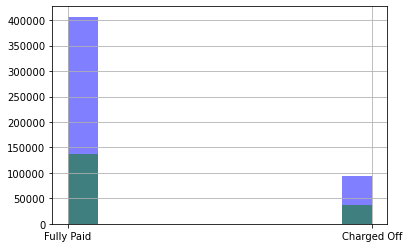

In [153]:
fig, ax = plt.subplots()

data[data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='blue')
data[~data['mths_since_last_major_derog'].isna()]['loan_status'].hist(ax = ax, alpha=.5, color='green')

<AxesSubplot:>

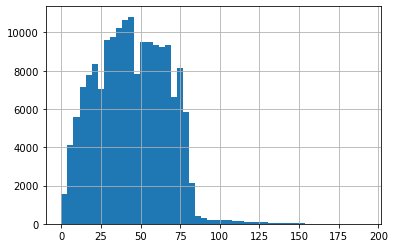

In [154]:
data['mths_since_last_major_derog'].hist(bins = 50)

In [196]:
# Create Test and Validation Set

data['year'].unique()

array([18, 13, 12, 14, 15, 20, 19, 17, 16])

<BarContainer object of 9 artists>

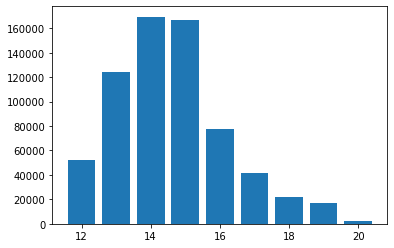

In [228]:
fig, ax = plt.subplots()

ax.bar(data['year'].value_counts().index,data['year'].value_counts() )

In [400]:
(data['year'] >= 16).sum()/data.shape[0]

0.23773873526004694

In [233]:
(data[data['year'] >= 17]['loan_status']=='Charged Off').sum()/data[data['year'] >= 17].shape[0]

0.08287779507415319

In [234]:
(data[data['year'] < 17]['loan_status']=='Charged Off').sum()/data[data['year'] < 17].shape[0]

0.2085436880049994

In [246]:
data[data['loan_status']=='Charged Off'].groupby('year')['year'].count()/data.groupby('year')['year'].count()

year
12    0.164491
13    0.160649
14    0.205134
15    0.264148
16    0.202681
17    0.118006
18    0.051843
19    0.044889
20    0.008303
Name: year, dtype: float64

In [ ]:
validation = data

In [335]:
drop.extend([
    'application_type', 
    'issue_d', 
    'id',
    'loan_status',
    'year'])

In [336]:

X = data.drop(drop, axis=1)
y = data['loan_status']

In [337]:
X.fillna(value=0.0, inplace=True)

In [338]:
y = y.apply(lambda x: 1 if x=='Charged Off' else 0)

In [339]:
dummies = ['sub_grade', 'verification_status', 'purpose','home_ownership']
X = pd.get_dummies(X, columns=dummies, drop_first=True)

In [264]:
# data['earliest_cr_line'] = data.earliest_cr_line.str.split('-', expand=True)[1]

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score

In [340]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [267]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.8221436984687868
Precision: 0.8043913386304361


In [268]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.8221436984687868
Precision: 0.8043913386304361


In [269]:
recall = recall_score(y_test, gb_model.predict(X_test))
precision = precision_score(y_test, gb_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.8307296509825801
Precision: 0.8003643313623604


In [270]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

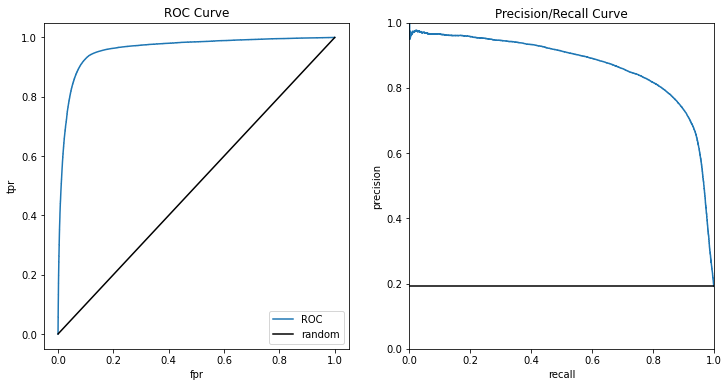

In [271]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(rf_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [341]:
probabilities = rf_model.predict_proba(X_test)

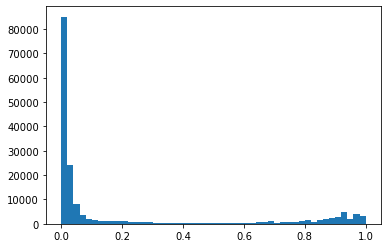

In [342]:
fig, ax = plt.subplots()
ax.hist(probabilities[:,1], bins=50);

In [274]:
(probabilities > .5).sum()

167955

In [275]:
y.sum()

130007

In [276]:
threshold = np.linspace(0,1,50)
yhat = rf_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

<ipython-input-276-6ed33272057a>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = c[1][1]/(c[1][1]+c[1][0])


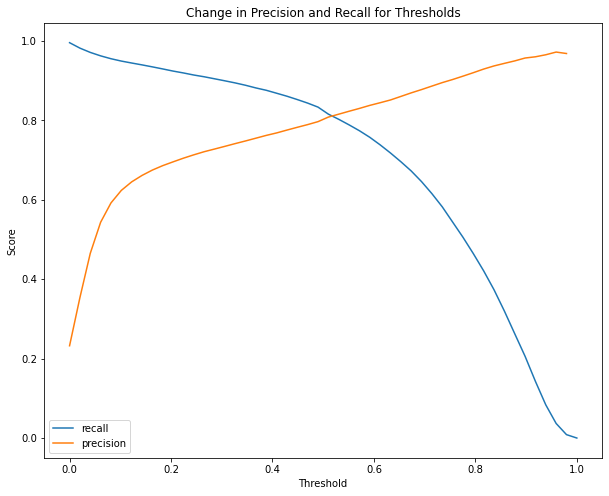

In [277]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()

In [278]:
y_prob = rf_model.predict_proba(X_test)[:,1]

In [279]:
# make predictions based on probabilities and threshold
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 1 is the positive class'''
    return np.where(model.predict_proba(X)[:,1] > threshold, 1, 0)

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, y,  threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=[0, 1], index=[0, 1]), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).values.sum()

In [280]:
rf_model.classes_

array([0, 1])

In [281]:
cf = confusion_matrix(rf_model, X_test, y_test)

In [282]:
cf

predicted,0,1
actual,,
0,129623,6450
1,5738,26524


In [283]:
cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [284]:
cb_matrix

predicted,0,1
actual,,
0,0,-20
1,0,10


In [285]:
calculate_payout(cb_matrix, rf_model, X_test, y_test, .5)

136240

In [286]:
-10*6414 + 26550 * 10

201360

In [287]:
# Cost benefit
def get_profits(model, X, y):
    cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.05)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, y, threshold))
    return profits
    
    
def profit_curve(profits, ax):
    thresholds = np.arange(0.0, 1.0, 0.05)
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')
    print(profits)

In [290]:
profits = get_profits(rf_model, X_test, y_test)

(-250000.0, 200000.0)

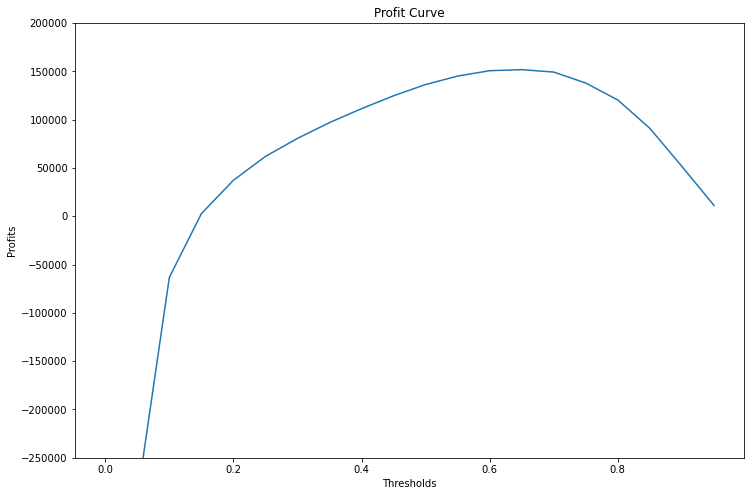

In [296]:
fig, ax = plt.subplots(figsize=(12, 8))
thresholds = np.arange(0.0, 1.0, 0.05)
ax.plot(thresholds, profits)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Profits')
ax.set_title('Profit Curve')
ax.set_ylim(-250000, 200000)

In [343]:
def get_yhat(probs, threshold):
    return probs > threshold

In [344]:
def get_cf_arrays(y_true, y_hat):
    true_positive = (y_true == 1) & (y_hat==1)
    true_negative = (y_true == 0) & (y_hat==0)
    false_positive = (y_true == 0) & (y_hat==1)
    false_negative = (y_true == 1) & (y_hat==0)
    return true_positive, true_negative, false_positive, false_negative

In [345]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .65))

In [346]:
tp.sum() + tn.sum() + fp.sum() + fn.sum()

168335

In [347]:
y_test.shape[0]

168335

In [348]:
data.loc[y_test.index[tp]]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,year
230834,4535404,NaN,17600,17600,17600.0,36,7.90,550.71,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
2474937,78869115,NaN,18000,18000,18000.0,36,13.67,612.32,C,C3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
249340,3379310,NaN,4650,4650,4650.0,36,16.29,164.15,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1478936,159580185,NaN,22325,22325,22325.0,60,20.55,598.33,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
454194,19165963,NaN,10000,10000,10000.0,60,14.49,235.24,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634924,75104057,NaN,7350,7350,7350.0,36,19.53,271.40,D,D5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
452099,19127753,NaN,16525,16525,16525.0,60,19.52,433.41,E,E2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
637297,63446874,NaN,1100,1100,1100.0,36,17.57,39.54,D,D4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
581095,66420629,NaN,10000,10000,10000.0,60,9.76,211.30,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15


In [355]:
payment = [
    'loan_amnt', 
    'funded_amnt',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee']

In [356]:
data.loc[y_test.index[tp]][payment]

,loan_amnt,funded_amnt,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee
230834,17600,17600,0.0,0.0,15250.80,15250.80,12287.22,2031.24,0.00
2474937,18000,18000,0.0,0.0,3677.20,3677.20,2509.42,1137.16,30.62
249340,4650,4650,0.0,0.0,3620.40,3620.40,2303.04,979.12,0.00
1478936,22325,22325,0.0,0.0,572.84,572.84,177.78,395.06,0.00
454194,10000,10000,0.0,0.0,5797.73,5797.73,2572.51,2132.29,0.00
...,...,...,...,...,...,...,...,...,...
2634924,7350,7350,0.0,0.0,1456.48,1456.48,462.78,300.32,0.00
452099,16525,16525,0.0,0.0,10764.49,10764.49,4312.36,5222.66,0.00
637297,1100,1100,0.0,0.0,590.95,590.95,389.93,201.02,0.00
581095,10000,10000,0.0,0.0,1983.13,1983.13,660.49,390.59,0.00


In [358]:
data[data.loan_amnt != data.funded_amnt][payment]

,loan_amnt,funded_amnt,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee
178659,5000,3400,0.0,0.0,3643.290000,3643.29,3400.00,243.29,0.0
179511,2875,2850,0.0,0.0,3181.145363,3181.15,2850.00,331.15,0.0
220369,32000,31900,0.0,0.0,33855.959850,33829.43,31900.00,1955.96,0.0
221038,25000,24975,0.0,0.0,26453.004910,26453.00,24975.00,1478.00,0.0
221199,27500,27475,0.0,0.0,38023.089990,38023.09,27475.00,10548.09,0.0
...,...,...,...,...,...,...,...,...,...
316580,20000,13675,0.0,0.0,14786.731120,7217.66,13675.00,1111.73,0.0
316582,17500,16800,0.0,0.0,4711.000000,4703.99,1662.30,3042.60,0.0
316583,35000,22550,0.0,0.0,22724.800000,22724.80,14480.92,8232.35,0.0
316586,20000,12675,0.0,0.0,17801.931680,17801.93,12675.00,5126.93,0.0


In [360]:
data.loc[:,payment].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673340 entries, 126 to 2854458
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   loan_amnt           673340 non-null  int64  
 1   funded_amnt         673340 non-null  int64  
 2   out_prncp           673340 non-null  float64
 3   out_prncp_inv       673340 non-null  float64
 4   total_pymnt         673340 non-null  float64
 5   total_pymnt_inv     673340 non-null  float64
 6   total_rec_prncp     673340 non-null  float64
 7   total_rec_int       673340 non-null  float64
 8   total_rec_late_fee  673340 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 67.5 MB


In [381]:
(data.loc[y_test.index[tp]]['funded_amnt'].sum()-data.loc[y_test.index[tp]]['total_rec_prncp'].sum())/y_test.index[tp].shape[0]

12041.977308466025

In [382]:
data.loc[y_test.index[fp]]['total_rec_int'].sum()

2283844.46

In [391]:
def potential_principal_saved(tp, fp, interest=False):
    # Principal remaining
    funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
    princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
    int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
    missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
    saved = funded - princ_rec - missed_int
    if interest:
        saved -= int_rec
    return saved
    

In [392]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp))

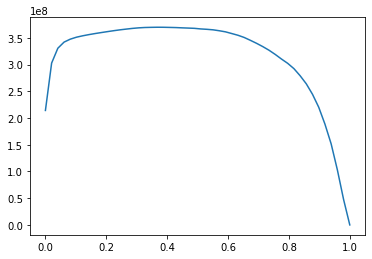

In [393]:
fig, ax = plt.subplots()

ax.plot(threshold, savings)

In [398]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp, True))


Text(0.5, 0, 'Threshold')

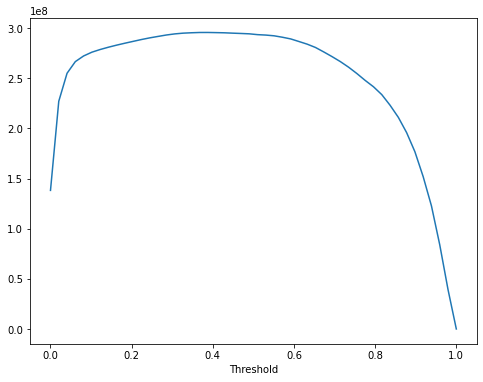

In [399]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, savings)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')

In [396]:
threshold[np.argmax(savings)]

0.3877551020408163